2024-04-12 20:13:15.604103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 20:13:15.604204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 20:13:15.770078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5140 validated image filenames belonging to 4 classes.
Found 572 validated image filenames.
58889256/58889256 [==============================] - 0s 0us/step
Found 1311 images belonging to 4 classes.
Epoch 1/10


I0000 00:00:1712952831.700817     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 13s 719ms/step
Found 5302 validated image filenames belonging to 4 classes.
41/41 - 19s - loss: 0.5012 - accuracy: 0.8024 - 19s/epoch - 472ms/step
Training Accuracy: 0.6795719861984253, Testing Accuracy: 0.802440881729126
Epoch 2/10
18/18 [==============================] - 3s 140ms/step
Found 5555 validated image filenames belonging to 4 classes.
41/41 - 6s - loss: 0.4037 - accuracy: 0.8581 - 6s/epoch - 144ms/step
Training Accuracy: 0.7851753830909729, Testing Accuracy: 0.8581235408782959
Epoch 3/10
18/18 [==============================] - 3s 142ms/step
Found 5880 validated image filenames belonging to 4 classes.
41/41 - 6s - loss: 0.3930 - accuracy: 0.8444 - 6s/epoch - 143ms/step
Training Accuracy: 0.8023402094841003, Testing Accuracy: 0.8443936109542847
Epoch 4/10
18/18 [==============================] - 3s 142ms/step
Found 6272 validated image filenames belonging to 4 classes.
41/41 - 6s - loss: 0.3452 - accuracy: 0.8680 - 6s/epoch - 145ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


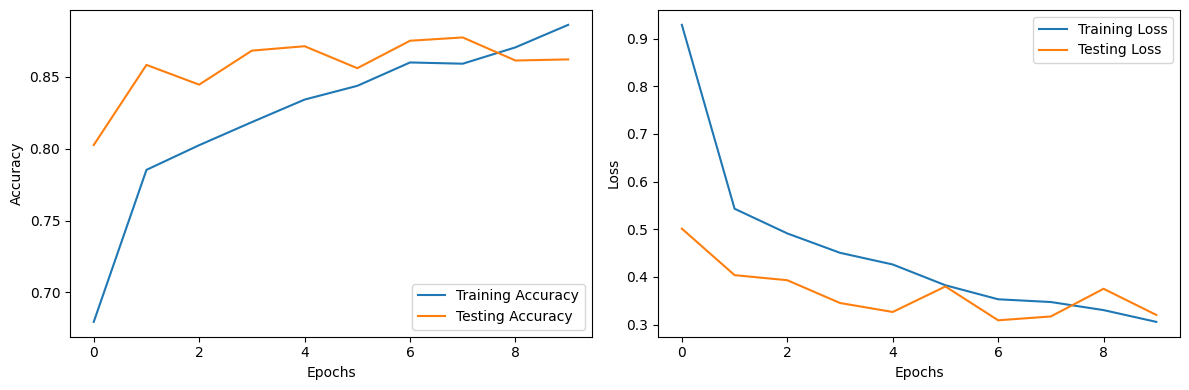

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Define data directories
train_data_directory = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_directory = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Define classes
classes = ["glioma", "meningioma", "notumor", "pituitary"]
num_classes = len(classes)

# Split labeled and unlabeled data
all_images = []
for class_name in classes:
    class_path = os.path.join(train_data_directory, class_name)
    image_files = os.listdir(class_path)
    all_images.extend([(os.path.join(class_name, img), class_name) for img in image_files])

# random.shuffle(all_images)

# Use 90% of labeled data and 20% as unlabeled data
num_labeled = int(0.9 * len(all_images))
labeled_data = all_images[:num_labeled]
unlabeled_data = all_images[num_labeled:]

# Convert data to DataFrame for flow_from_dataframe
labeled_df = pd.DataFrame(labeled_data, columns=['Image', 'Label'])
unlabeled_df = pd.DataFrame(unlabeled_data, columns=['Image', 'Label'])

# Define data generators for labeled and unlabeled data
batch_size = 32
image_size = (224, 224)

labeled_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

labeled_generator = labeled_datagen.flow_from_dataframe(
    labeled_df,
    directory=train_data_directory,
    x_col='Image',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)

unlabeled_datagen = ImageDataGenerator(rescale=1./255)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    unlabeled_df,
    directory=train_data_directory,
    x_col='Image',
    y_col=None,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None
)

# Create a simple VGG16-based model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)
num_epochs = 10
training_loss_history = []
training_accuracy_history = []
validation_loss_history = []
validation_accuracy_history = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train on labeled data
    history = model.fit(
        labeled_generator,
        steps_per_epoch=len(labeled_generator),
        epochs=1,
    )

    # Append training history
    training_loss_history.append(history.history['loss'][0])
    training_accuracy_history.append(history.history['accuracy'][0])

    # Predict labels for unlabeled data
    unlabeled_predictions = model.predict(unlabeled_generator)

    # Identify confident predictions
    confident_indices = np.max(unlabeled_predictions, axis=1) > 0.9
    confident_data = [unlabeled_data[i] for i in range(len(unlabeled_data)) if confident_indices[i]]

    # Add confident predictions to labeled set
    labeled_data.extend(confident_data)

    # Update data generators with the new labeled data
    labeled_df = pd.DataFrame(labeled_data, columns=['Image', 'Label'])
    labeled_generator = labeled_datagen.flow_from_dataframe(
        labeled_df,
        directory=train_data_directory,
        x_col='Image',
        y_col='Label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes=classes
    )

    # Evaluate on the validation set
    validation_loss, validation_accuracy = model.evaluate(test_generator, verbose=2)
    validation_loss_history.append(validation_loss)
    validation_accuracy_history.append(validation_accuracy)
    print(f"Training Accuracy: {training_accuracy_history[-1]}, Testing Accuracy: {validation_accuracy_history[-1]}")

# Save the trained model
model.save("/content/trained_model.h5")

# Plotting the accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy_history, label='Training Accuracy')
plt.plot(validation_accuracy_history, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


41/41 [==============================] - 6s 145ms/step


NameError: name 'interp' is not defined

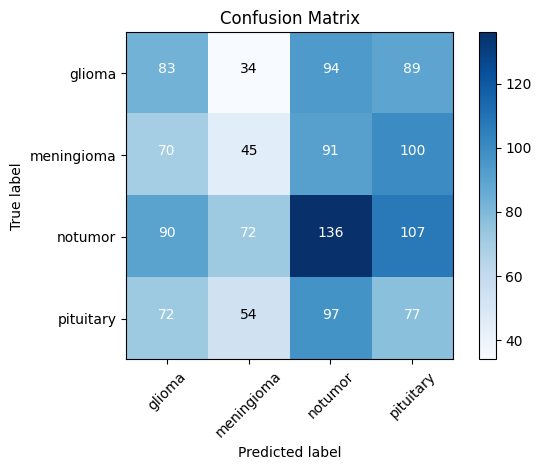

In [10]:

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.utils.multiclass import unique_labels
from scipy.interpolate import interp

import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils.multiclass import unique_labels
# Load the trained model
loaded_model = tf.keras.models.load_model("/content/trained_model.h5")

# Predict labels for the test set
y_true = test_generator.classes
y_pred = loaded_model.predict(test_generator)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Interpolate ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 8))

    colors = plt.cm.get_cmap('tab10', len(classes))
    for i, color in zip(range(len(classes)), colors(range(len(classes)))):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix')

# Convert labels to one-hot encoding
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))
y_pred_one_hot = y_pred

# Plot ROC Curve
plot_roc_curve(y_true_one_hot, y_pred_one_hot, classes)


In [7]:
!pip install --upgrade --force-reinstall scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 960.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 33.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 60.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not i